In [1]:
pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/khushikimmatka/ap-refined-optical-coherence-tomography-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aaryanstark
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/khushikimmatka/ap-refined-optical-coherence-tomography-images


In [4]:
from google.colab import files
uploaded = files.upload()

Saving AP_GLCM_FEATURES.zip to AP_GLCM_FEATURES.zip


In [8]:
# Once the file is uploaded, unzip it
import zipfile
zip_file_path = next(iter(uploaded))  # Get the uploaded file name
unzip_dir = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f"Files extracted to {unzip_dir}")

Files extracted to /content/


In [16]:
import joblib
# --- Define training GLCM feature directory ---
glcm_train_feature_dir = "/content/GLCM_FEATURES/Train"

# --- Gather all GLCM training feature paths ---
glcm_train_paths = {}
for class_name in os.listdir(glcm_train_feature_dir):
    class_dir = os.path.join(glcm_train_feature_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    for f in os.listdir(class_dir):
        if f.endswith('.npy'):
            file_id = os.path.splitext(f)[0]
            glcm_train_paths[file_id] = os.path.join(class_dir, f)

# --- Use first 1000 samples to fit the scaler ---
train_glcm_paths = list(glcm_train_paths.values())[:1000]
sample_glcm_features = np.array([np.load(p) for p in train_glcm_paths])
scaler = StandardScaler().fit(sample_glcm_features)
joblib.dump(scaler, "saved_scaler.pkl")


['saved_scaler.pkl']

In [13]:
# i think the label 1 for DME is not confirm provide it explicitly then and print the class labels with its name for confimation
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# --- Configuration ---
image_size = (224, 224)
dme_image_dir = "/content/ap-refined-optical-coherence-tomography-images/OCT2017_ap/test/DME"
glcm_feature_dir = "/content/GLCM_FEATURES/test/DME"
model_path = "/content/drive/MyDrive/OCT/Project Assets/GLCM Features /checkpoint_epoch_21.keras"  # replace with your model path

# --- Load the trained model ---
model = load_model(model_path)
print(os.path.exists(model_path))
print("✅ Model loaded successfully.")
# model.summary()
# --- Load and scale GLCM features ---
glcm_feature_paths = {os.path.splitext(f)[0]: os.path.join(glcm_feature_dir, f)
                      for f in os.listdir(glcm_feature_dir) if f.endswith('.npy')}

# Build scaler using training logic again (ensure consistency)
# (OPTIONAL: You can also save and load the scaler instead of refitting)
train_glcm_paths = list(glcm_train_paths.values())[:1000]
sample_glcm_features = np.array([np.load(p) for p in train_glcm_paths])
scaler = StandardScaler().fit(sample_glcm_features)

# --- Load DME images and corresponding GLCM features ---
image_data = []
glcm_data = []
true_labels = []

for fname in os.listdir(dme_image_dir):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')): continue

    file_id = os.path.splitext(fname)[0]
    glcm_path = glcm_feature_paths.get(file_id)

    if not glcm_path:
        print(f"Missing GLCM feature for {fname}, skipping.")
        continue

    # Load image
    img = load_img(os.path.join(dme_image_dir, fname), target_size=image_size)
    img_array = img_to_array(img) / 255.0
    image_data.append(img_array)

    # Load and scale GLCM
    glcm_feat = np.load(glcm_path)
    glcm_feat_scaled = scaler.transform([glcm_feat])[0]
    glcm_data.append(glcm_feat_scaled)

    # Append true label (index for 'DME')
    true_labels.append(1)  # assuming class indices: 0=CNV, 1=DME, 2=DRUSEN, 3=NORMAL
class_labels = ["CNV", "DME", "DRUSEN", "NORMAL"]
for index, label in enumerate(class_labels):
    print(f"Class {index}: {label}")
# --- Predict ---
image_data = np.array(image_data)
glcm_data = np.array(glcm_data)

pred_probs = model.predict([image_data, glcm_data], batch_size=32)
pred_labels = np.argmax(pred_probs, axis=1)

# --- Report ---
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["CNV", "DME", "DRUSEN", "NORMAL"]))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))


True
✅ Model loaded successfully.
Class 0: CNV
Class 1: DME
Class 2: DRUSEN
Class 3: NORMAL
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step

Classification Report:
              precision    recall  f1-score   support

         CNV       0.00      0.00      0.00         0
         DME       1.00      0.97      0.99      1102
      DRUSEN       0.00      0.00      0.00         0
      NORMAL       0.00      0.00      0.00         0

    accuracy                           0.97      1102
   macro avg       0.25      0.24      0.25      1102
weighted avg       1.00      0.97      0.99      1102


Confusion Matrix:
[[   0    0    0    0]
 [  16 1070    1   15]
 [   0    0    0    0]
 [   0    0    0    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# --- Configuration ---
image_size = (224, 224)
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]
base_image_dir = "/content/ap-refined-optical-coherence-tomography-images/OCT2017_ap/test"
base_glcm_dir = "/content/GLCM_FEATURES/test"
model_path = "/content/drive/MyDrive/OCT/Project Assets/GLCM Features /checkpoint_epoch_21.keras"

# --- Load the trained model ---
model = load_model(model_path)

# --- Load scaler ---
scaler = joblib.load("/content/saved_scaler.pkl")  # Path to previously saved scaler

# --- Initialize holders ---
image_data_all = []
glcm_data_all = []
true_labels_all = []

# --- Process each class ---
for class_index, class_name in enumerate(classes):
    image_dir = os.path.join(base_image_dir, class_name)
    glcm_dir = os.path.join(base_glcm_dir, class_name)

    # Map GLCM file paths
    glcm_feature_paths = {os.path.splitext(f)[0]: os.path.join(glcm_dir, f)
                          for f in os.listdir(glcm_dir) if f.endswith('.npy')}

    for fname in os.listdir(image_dir):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        file_id = os.path.splitext(fname)[0]
        glcm_path = glcm_feature_paths.get(file_id)

        if not glcm_path:
            print(f"Missing GLCM feature for {fname}, skipping.")
            continue

        # Load and preprocess image
        img = load_img(os.path.join(image_dir, fname), target_size=image_size)
        img_array = img_to_array(img) / 255.0
        image_data_all.append(img_array)

        # Load and scale GLCM feature
        glcm_feat = np.load(glcm_path)
        glcm_feat_scaled = scaler.transform([glcm_feat])[0]
        glcm_data_all.append(glcm_feat_scaled)

        # Append true label
        true_labels_all.append(class_index)

# --- Convert to NumPy arrays ---
image_data_all = np.array(image_data_all)
glcm_data_all = np.array(glcm_data_all)
true_labels_all = np.array(true_labels_all)

# --- Predict ---
pred_probs = model.predict([image_data_all, glcm_data_all], batch_size=32)
pred_labels = np.argmax(pred_probs, axis=1)

# --- Report ---
print("\n✅ Classification Report:")
print(classification_report(true_labels_all, pred_labels, target_names=classes))

print("\n✅ Confusion Matrix:")
print(confusion_matrix(true_labels_all, pred_labels))


In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# --- Configuration ---
image_size = (224, 224)
classes = ["CNV", "DME", "DRUSEN", "NORMAL"]
base_image_dir = "/content/ap-refined-optical-coherence-tomography-images/OCT2017_ap/test"
base_glcm_dir = "/content/GLCM_FEATURES/test"
model_path = "/content/drive/MyDrive/OCT/Project Assets/GLCM Features /checkpoint_epoch_21.keras"
scaler_path = "/content/saved_scaler.pkl"

# --- Load model and scaler ---
model = load_model(model_path)
scaler = joblib.load(scaler_path)

# --- Accumulators ---
all_true_labels = []
all_pred_labels = []

# --- Process each class separately ---
for class_index, class_name in enumerate(classes):
    print(f"\n🔄 Processing class: {class_name}")
    image_dir = os.path.join(base_image_dir, class_name)
    glcm_dir = os.path.join(base_glcm_dir, class_name)

    glcm_feature_paths = {
        os.path.splitext(f)[0]: os.path.join(glcm_dir, f)
        for f in os.listdir(glcm_dir) if f.endswith('.npy')
    }

    for fname in os.listdir(image_dir):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        file_id = os.path.splitext(fname)[0]
        glcm_path = glcm_feature_paths.get(file_id)

        if not glcm_path:
            print(f"❌ Missing GLCM feature for {fname}, skipping.")
            continue

        # Load image
        try:
            img = load_img(os.path.join(image_dir, fname), target_size=image_size)
            img_array = img_to_array(img) / 255.0
        except Exception as e:
            print(f"⚠️ Error loading image {fname}: {e}")
            continue

        # Load and scale GLCM
        try:
            glcm_feat = np.load(glcm_path)
            glcm_feat_scaled = scaler.transform([glcm_feat])
        except Exception as e:
            print(f"⚠️ Error loading GLCM feature {glcm_path}: {e}")
            continue

        # Predict
        pred = model.predict([np.expand_dims(img_array, axis=0), glcm_feat_scaled], verbose=0)
        pred_label = np.argmax(pred, axis=1)[0]

        # Store results
        all_true_labels.append(class_index)
        all_pred_labels.append(pred_label)

# --- Final Report ---
print("\n✅ Classification Report:")
print(classification_report(all_true_labels, all_pred_labels, target_names=classes))

print("\n✅ Confusion Matrix:")
print(confusion_matrix(all_true_labels, all_pred_labels))



🔄 Processing class: CNV

🔄 Processing class: DME

🔄 Processing class: DRUSEN

🔄 Processing class: NORMAL

✅ Classification Report:
              precision    recall  f1-score   support

         CNV       0.99      0.98      0.98      3145
         DME       0.95      0.97      0.96      1102
      DRUSEN       0.89      0.95      0.92       802
      NORMAL       0.98      0.97      0.98      2616

    accuracy                           0.97      7665
   macro avg       0.95      0.97      0.96      7665
weighted avg       0.97      0.97      0.97      7665


✅ Confusion Matrix:
[[3067   17   59    2]
 [  16 1070    1   15]
 [  13    1  764   24]
 [   1   41   35 2539]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# --- Replace with your actual labels ---
y_true = all_true_labels
y_pred = all_pred_labels
class_names = ["CNV", "DME", "DRUSEN", "NORMAL"]

# --- 1. Classification Report as DataFrame ---
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\n📋 Classification Report Table:\n")
print(report_df)

# --- 2. Save report to CSV (optional) ---
report_df.to_csv("classification_report.csv")

# --- 3. Confusion Matrix ---
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# --- 4. Bar Plot for Precision, Recall, F1-Score ---
metrics_to_plot = ['precision', 'recall', 'f1-score']
colors = ['#4CAF50', '#2196F3', '#FFC107']  # green, blue, yellow

for metric, color in zip(metrics_to_plot, colors):
    plt.figure(figsize=(7, 4))
    sns.barplot(x=class_names, y=[report_dict[label][metric] for label in class_names], palette=[color])
    plt.title(f"{metric.title()} per Class")
    plt.ylim(0, 1)
    plt.ylabel(metric.title())
    plt.xlabel("Class")
    plt.tight_layout()
    plt.savefig(f"{metric}_per_class.png")
    plt.show()

# --- 5. Save predictions (optional) ---
results_df = pd.DataFrame({
    "True Label": [class_names[i] for i in y_true],
    "Predicted Label": [class_names[i] for i in y_pred]
})
results_df.to_csv("detailed_predictions.csv", index=False)


<ipython-input-3-2cbf242a35d3>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(overall_metrics.keys()), y=list(overall_metrics.values()), palette="viridis")


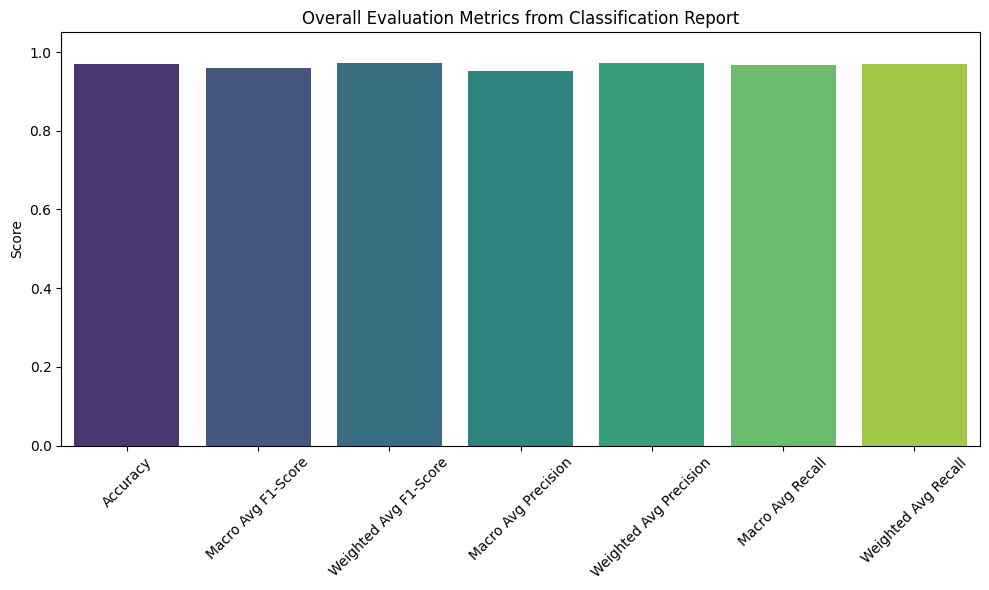

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

# --- Use this if you already have classification_report as a dictionary ---
report_dict = classification_report(y_true, y_pred, target_names=["CNV", "DME", "DRUSEN", "NORMAL"], output_dict=True)

# Extract overall metrics
overall_metrics = {
    "Accuracy": report_dict["accuracy"],
    "Macro Avg F1-Score": report_dict["macro avg"]["f1-score"],
    "Weighted Avg F1-Score": report_dict["weighted avg"]["f1-score"],
    "Macro Avg Precision": report_dict["macro avg"]["precision"],
    "Weighted Avg Precision": report_dict["weighted avg"]["precision"],
    "Macro Avg Recall": report_dict["macro avg"]["recall"],
    "Weighted Avg Recall": report_dict["weighted avg"]["recall"]
}

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(overall_metrics.keys()), y=list(overall_metrics.values()), palette="viridis")
plt.ylim(0, 1.05)
plt.title("Overall Evaluation Metrics from Classification Report")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("overall_metrics_summary.png")
plt.show()


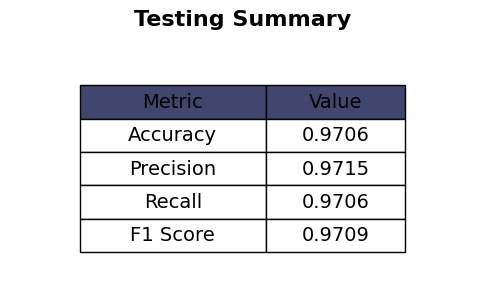

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import seaborn as sns

# Assume y_true and y_pred are already available
# y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
report = classification_report(y_true, y_pred, target_names=["CNV", "DME", "DRUSEN", "NORMAL"], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)

# Extract key metrics
precision = report["weighted avg"]["precision"]
recall = report["weighted avg"]["recall"]
f1 = report["weighted avg"]["f1-score"]

# Plotting
fig, ax = plt.subplots(figsize=(6, 3))
plt.axis('off')

metrics = {
    "Accuracy": f"{accuracy:.4f}",
    "Precision": f"{precision:.4f}",
    "Recall": f"{recall:.4f}",
    "F1 Score": f"{f1:.4f}"
}

# Create a table-like box
table_data = [[key, val] for key, val in metrics.items()]
table = plt.table(cellText=table_data,
                  colLabels=["Metric", "Value"],
                  cellLoc='center',
                  loc='center',
                  colColours=["#40466e", "#40466e"],
                  colWidths=[0.4, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2)

# Title
plt.title("Testing Summary", fontsize=16, weight='bold', pad=20)
plt.show()


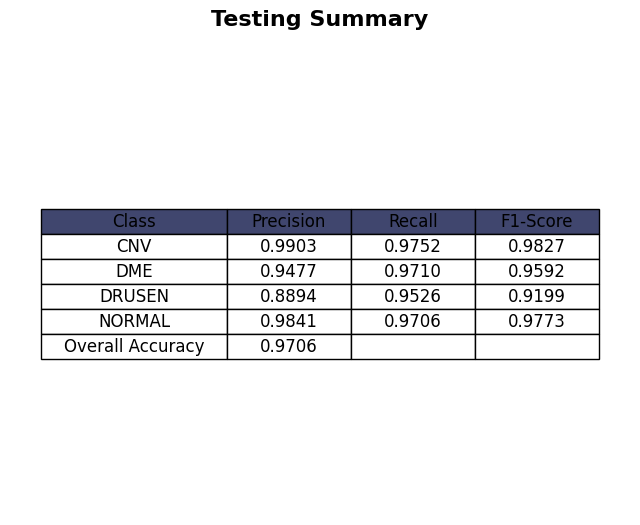

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Assume y_true and y_pred are already available
# y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
report = classification_report(y_true, y_pred, target_names=["CNV", "DME", "DRUSEN", "NORMAL"], output_dict=True)
accuracy = accuracy_score(y_true, y_pred)

# Extract key metrics for each class
class_metrics = {
    "CNV": report["CNV"],
    "DME": report["DME"],
    "DRUSEN": report["DRUSEN"],
    "NORMAL": report["NORMAL"]
}

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
plt.axis('off')

# Create a table-like box for individual class metrics
table_data = [
    ["CNV", f"{class_metrics['CNV']['precision']:.4f}", f"{class_metrics['CNV']['recall']:.4f}", f"{class_metrics['CNV']['f1-score']:.4f}"],
    ["DME", f"{class_metrics['DME']['precision']:.4f}", f"{class_metrics['DME']['recall']:.4f}", f"{class_metrics['DME']['f1-score']:.4f}"],
    ["DRUSEN", f"{class_metrics['DRUSEN']['precision']:.4f}", f"{class_metrics['DRUSEN']['recall']:.4f}", f"{class_metrics['DRUSEN']['f1-score']:.4f}"],
    ["NORMAL", f"{class_metrics['NORMAL']['precision']:.4f}", f"{class_metrics['NORMAL']['recall']:.4f}", f"{class_metrics['NORMAL']['f1-score']:.4f}"],
    ["Overall Accuracy", f"{accuracy:.4f}", "", ""]
]

# Create table with class-specific metrics
table = plt.table(cellText=table_data,
                  colLabels=["Class", "Precision", "Recall", "F1-Score"],
                  cellLoc='center',
                  loc='center',
                  colColours=["#40466e", "#40466e", "#40466e", "#40466e"],
                  colWidths=[0.3, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Title
plt.title("Testing Summary", fontsize=16, weight='bold', pad=20)
plt.show()


In [14]:
from google.colab import files
uploaded = files.upload()

Saving training_log1.csv to training_log1.csv


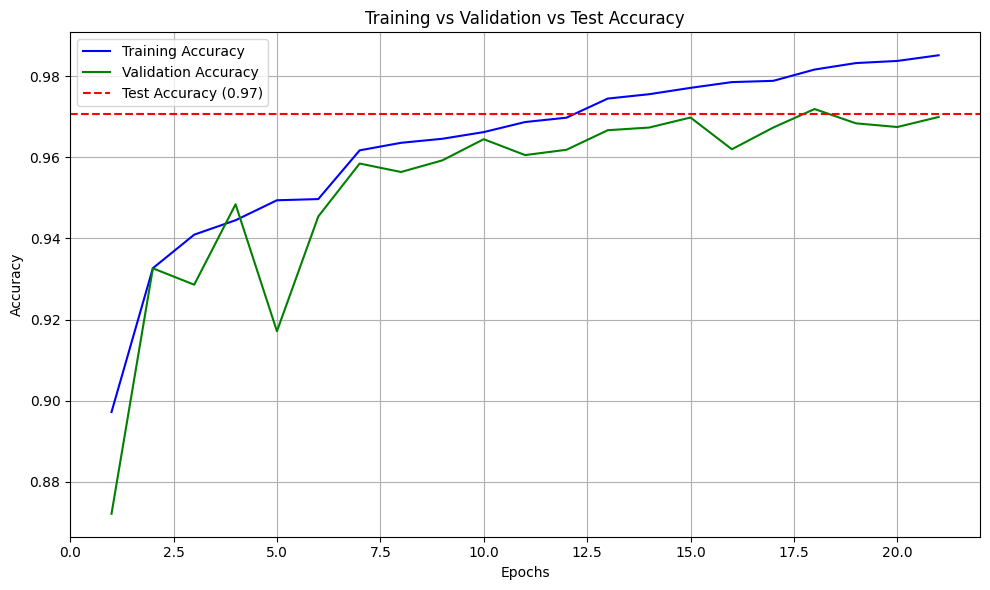

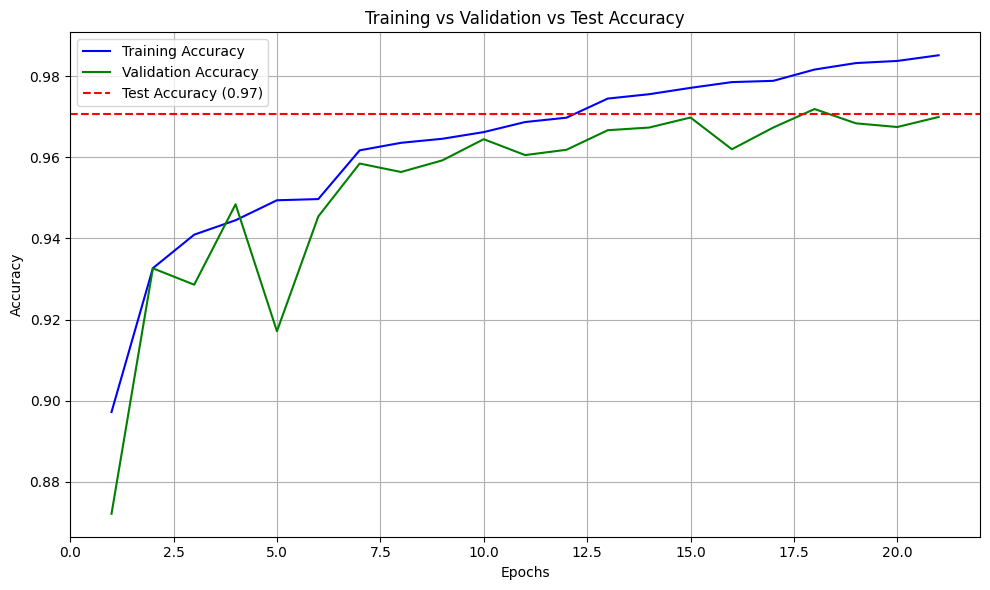

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training log
log_df = pd.read_csv('/content/training_log1.csv')  # Update the path if needed

# Compute testing accuracy from classification report (already available)
test_accuracy = 0.9706  # Replace with actual test accuracy from your evaluation

# Get epoch count
epochs = range(1, len(log_df) + 1)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, log_df['accuracy'], label='Training Accuracy', color='blue')
plt.plot(epochs, log_df['val_accuracy'], label='Validation Accuracy', color='green')

# Plot Test Accuracy as horizontal line
plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f'Test Accuracy ({test_accuracy:.2f})')

# Labels and styling
plt.title('Training vs Validation vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


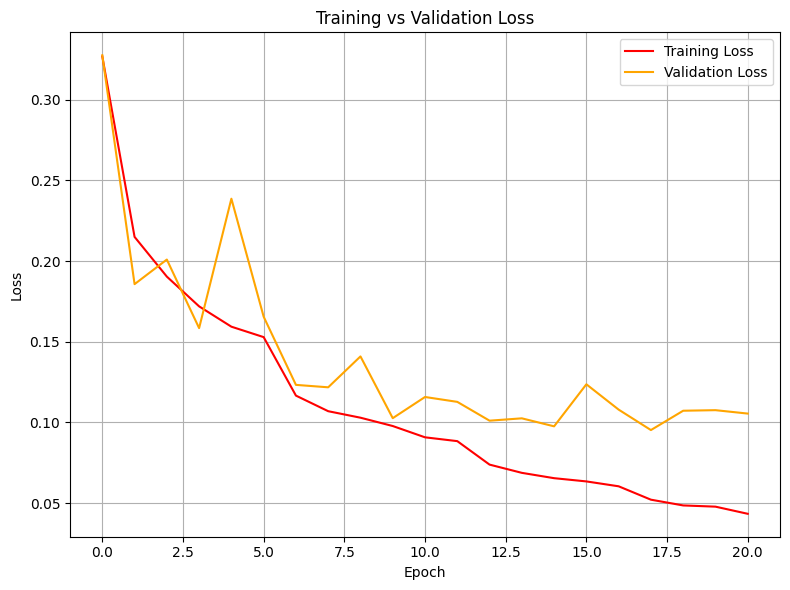

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training log
log_df = pd.read_csv('/content/training_log1.csv')  # Replace with your actual path

# Plot Training vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(log_df['epoch'], log_df['loss'], 'r-', label='Training Loss')
plt.plot(log_df['epoch'], log_df['val_loss'], 'orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Available columns: Index(['epoch', 'accuracy', 'learning_rate', 'loss', 'val_accuracy',
       'val_loss'],
      dtype='object')


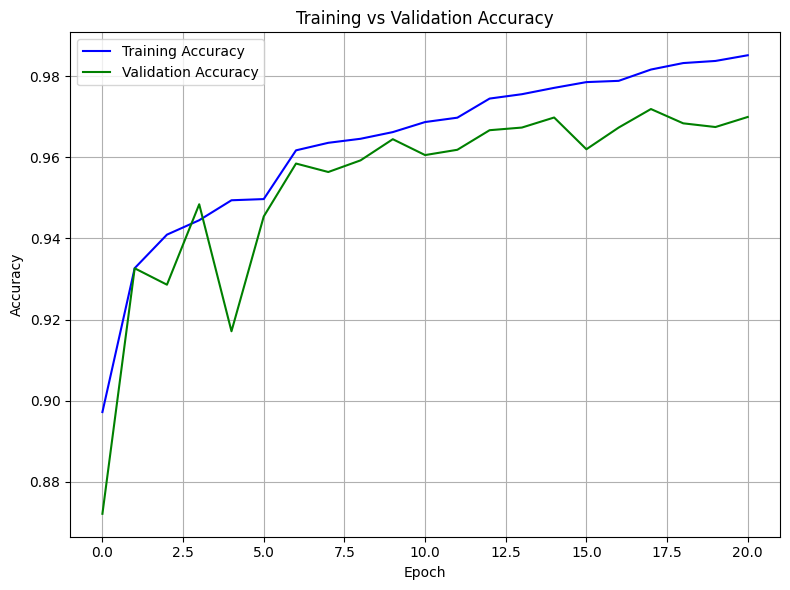

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
log_df = pd.read_csv('/content/training_log1.csv')  # change path as needed

# Check available columns
print("Available columns:", log_df.columns)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(log_df['epoch'], log_df['accuracy'], 'b-', label='Training Accuracy')
plt.plot(log_df['epoch'], log_df['val_accuracy'], 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


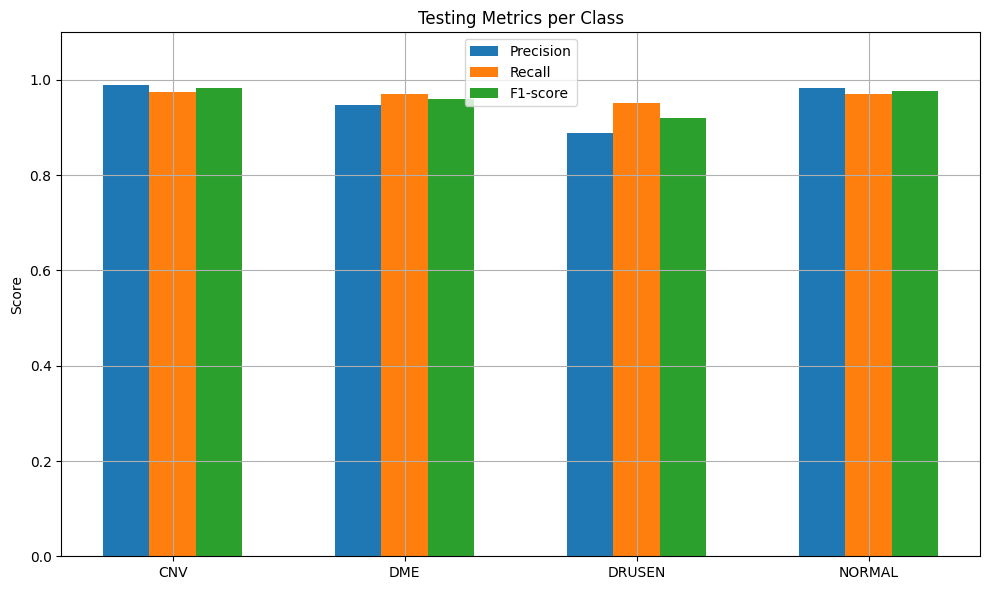

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Get classification report in dict format
report = classification_report(y_true, y_pred, target_names=["CNV", "DME", "DRUSEN", "NORMAL"], output_dict=True)

# Extract metrics
class_names = ["CNV", "DME", "DRUSEN", "NORMAL"]
precision = [report[cls]['precision'] for cls in class_names]
recall = [report[cls]['recall'] for cls in class_names]
f1_score = [report[cls]['f1-score'] for cls in class_names]
support = [report[cls]['support'] for cls in class_names]

x = np.arange(len(class_names))
width = 0.2

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-score')

# Add labels and title
plt.xticks(x, class_names)
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.title('Testing Metrics per Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
